In [1]:
import zipfile
import os
import pandas as pd
# Define the path to  ZIP file
zip_file_paths = ['/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip', '/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip']

# Define the extraction directory
extraction_dir = '/kaggle/working/extracted'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Extract the ZIP file
for i in zip_file_paths:
    with zipfile.ZipFile(i, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)

# List the contents of the extraction directory
extracted_files = os.listdir(extraction_dir)
print("Extracted files:", extracted_files)

# Read the data
train = pd.read_csv('/kaggle/working/extracted/labeledTrainData.tsv', delimiter='\t')
test = pd.read_csv('/kaggle/working/extracted/testData.tsv', delimiter='\t')

Extracted files: ['testData.tsv', 'labeledTrainData.tsv']


In [2]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
# Function to clean the text
def clean_text(raw_text):
    # Remove HTML markup
    text_no_html = BeautifulSoup(raw_text, 'html.parser').get_text()
    
    # Remove non-letters, keep only letters
    letters_only = re.sub("[^a-zA-Z]", " ", text_no_html)
    
    # Convert to lowercase and split into words
    words = letters_only.lower().split()
    
    # Convert stopwords to a set for faster processing
    stops = set(stopwords.words("english"))
    
    # Remove stopwords
    meaningful_words = [w for w in words if not w in stops]
    
    # Join the words back into one string separated by space
    return " ".join(meaningful_words)

# Apply cleaning to the training set
train['clean_review'] = train['review'].apply(clean_text)

# Initialize the CountVectorizer
vectorizer = CountVectorizer(analyzer='word', tokenizer=None, preprocessor=None, stop_words=None, max_features=5000, ngram_range=(1, 2))

# Fit and transform the vectorizer to the training data
train_data_features = vectorizer.fit_transform(train['clean_review'])

# Convert the result to an array
train_data_features = train_data_features.toarray()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_42/3341294549.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text_no_html = BeautifulSoup(raw_text, 'html.parser').get_text()


# VotingClassifier with **Random Forest** and **XGBClassifier**

In [3]:

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier




# Initialize models
random_forest = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier()

# Create a Voting Classifier with RandomForest and XGBoost
voting_classifier = VotingClassifier(estimators=[('rf', random_forest), ('xgb', xgb)], voting='soft')

# Train the Voting Classifier on the training data
voting_classifier.fit(train_data_features, train['sentiment'])

# Apply the same cleaning to the test set
test['clean_review'] = test['review'].apply(clean_text)

# Transform the test data
test_data_features = vectorizer.transform(test['clean_review'])
test_data_features = test_data_features.toarray()

# Predict sentiment for the test set
result = voting_classifier.predict(test_data_features)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [4]:
def predict_sentiment(sentence, model, vectorizer):
    cleaned_sentence = clean_text(sentence) 
    # Transform the cleaned sentence using the vectorizer
    sequence = vectorizer.transform([cleaned_sentence])
    prediction = model.predict(sequence)[0]
    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment, sentence
# Function to visualize predictions
def visualize_predictions(sentences, model, vectorizer):
    for sentence in sentences:
        sentiment, original_sentence = predict_sentiment(sentence, model, vectorizer)
        print(f"Review: {original_sentence} | Predicted Sentiment: {sentiment}")
        print("--------------------------------------------------")

In [5]:
# Example sentences for visualization
example_sentences = [
    "This movie was fantastic, I loved it!",
    "This movie is a disaster,it is so awful that once you know what is coming,Look away and spend your time on more meaningful content.",
    "The performance was average, but the story was captivating."
]
# Visualize predictions for the example sentences
visualize_predictions(example_sentences, voting_classifier, vectorizer)

Review: This movie was fantastic, I loved it! | Predicted Sentiment: Positive
--------------------------------------------------
Review: This movie is a disaster,it is so awful that once you know what is coming,Look away and spend your time on more meaningful content. | Predicted Sentiment: Negative
--------------------------------------------------
Review: The performance was average, but the story was captivating. | Predicted Sentiment: Positive
--------------------------------------------------


In [6]:

# Create a submission file (86% test accuracy)
submission = pd.DataFrame({'id': test['id'], 'sentiment': result})
submission.to_csv('submission.csv', index=False)

# **LSTM**

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split



# Tokenizing text and converting into sequences
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(train['clean_review'])
X = tokenizer.texts_to_sequences(train['clean_review'])
X = pad_sequences(X, maxlen=200)

# Splitting data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, train['sentiment'], test_size=0.2, random_state=42)

# Model architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(512, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
313/313 [==============================] - 476s 1s/step - loss: 0.4297 - accuracy: 0.8048 - val_loss: 0.3469 - val_accuracy: 0.8584
Epoch 2/10
313/313 [==============================] - 441s 1s/step - loss: 0.2770 - accuracy: 0.8916 - val_loss: 0.3161 - val_accuracy: 0.8736
Epoch 3/10
313/313 [==============================] - 435s 1s/step - loss: 0.2298 - accuracy: 0.9126 - val_loss: 0.3351 - val_accuracy: 0.8616
Epoch 4/10
313/313 [==============================] - 428s 1s/step - loss: 0.1909 - accuracy: 0.9293 - val_loss: 0.3513 - val_accuracy: 0.8672
Epoch 5/10
313/313 [==============================] - 430s 1s/step - loss: 0.1521 - accuracy: 0.9445 - val_loss: 0.3900 - val_accuracy: 0.8622
Epoch 6/10
313/313 [==============================] - 426s 1s/step - loss: 0.1218 - accuracy: 0.9573 - val_loss: 0.4182 - val_accuracy: 0.8606
Epoch 7/10
313/313 [==============================] - 423s 1s/step - loss: 0.1043 - accuracy: 0.9644 - val_loss: 0.4722 - val_accuracy: 0.8594

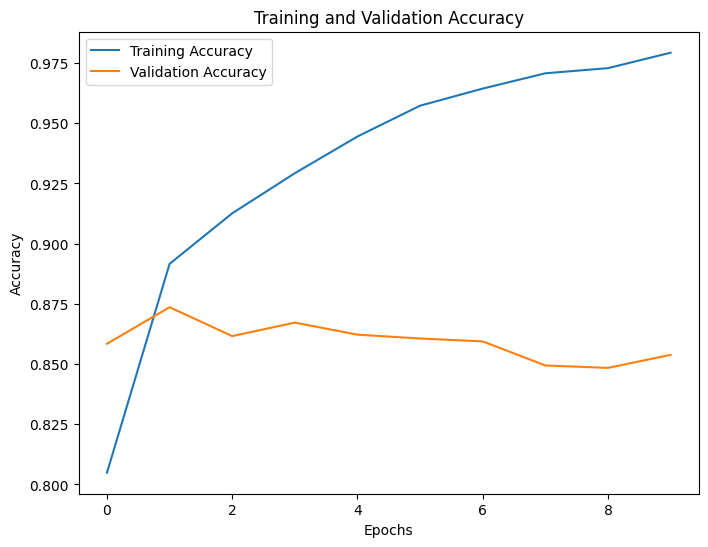

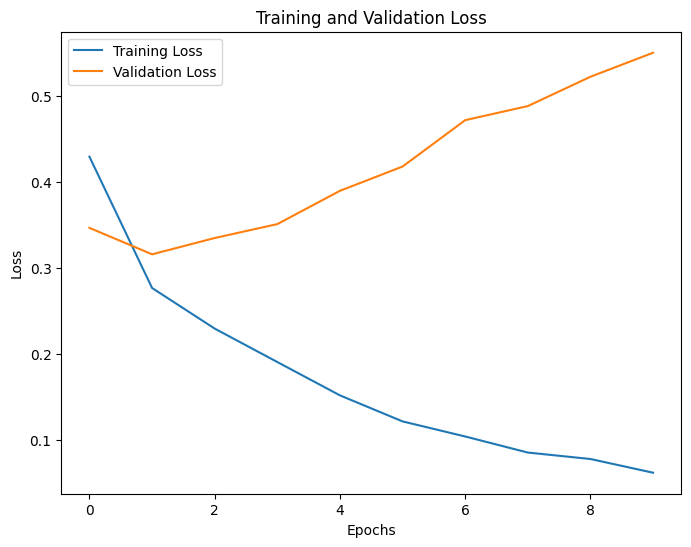

In [8]:
import matplotlib.pyplot as plt

# Visualize training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Preprocess the test data
X_test = tokenizer.texts_to_sequences(test['clean_review'])
X_test = pad_sequences(X_test, maxlen=200)

# Predict sentiment for the test set
result_dl = model.predict(X_test)

782/782 [==============================] - 77s 98ms/step


In [10]:
# Create a submission file (92% test accuracy)
submission = pd.DataFrame({'id': test['id'], 'sentiment': result_dl.flatten()})
submission.to_csv('submission.csv', index=False)